In [1]:
import numpy as np
import matplotlib.pyplot as plt

from simAnnealing import ciudades
from IPython.display import clear_output

from tsp import metodo_vecino_cercano
from genetic import GeneticAlgorithm

Generación 248/300
Distancia total = 8.64


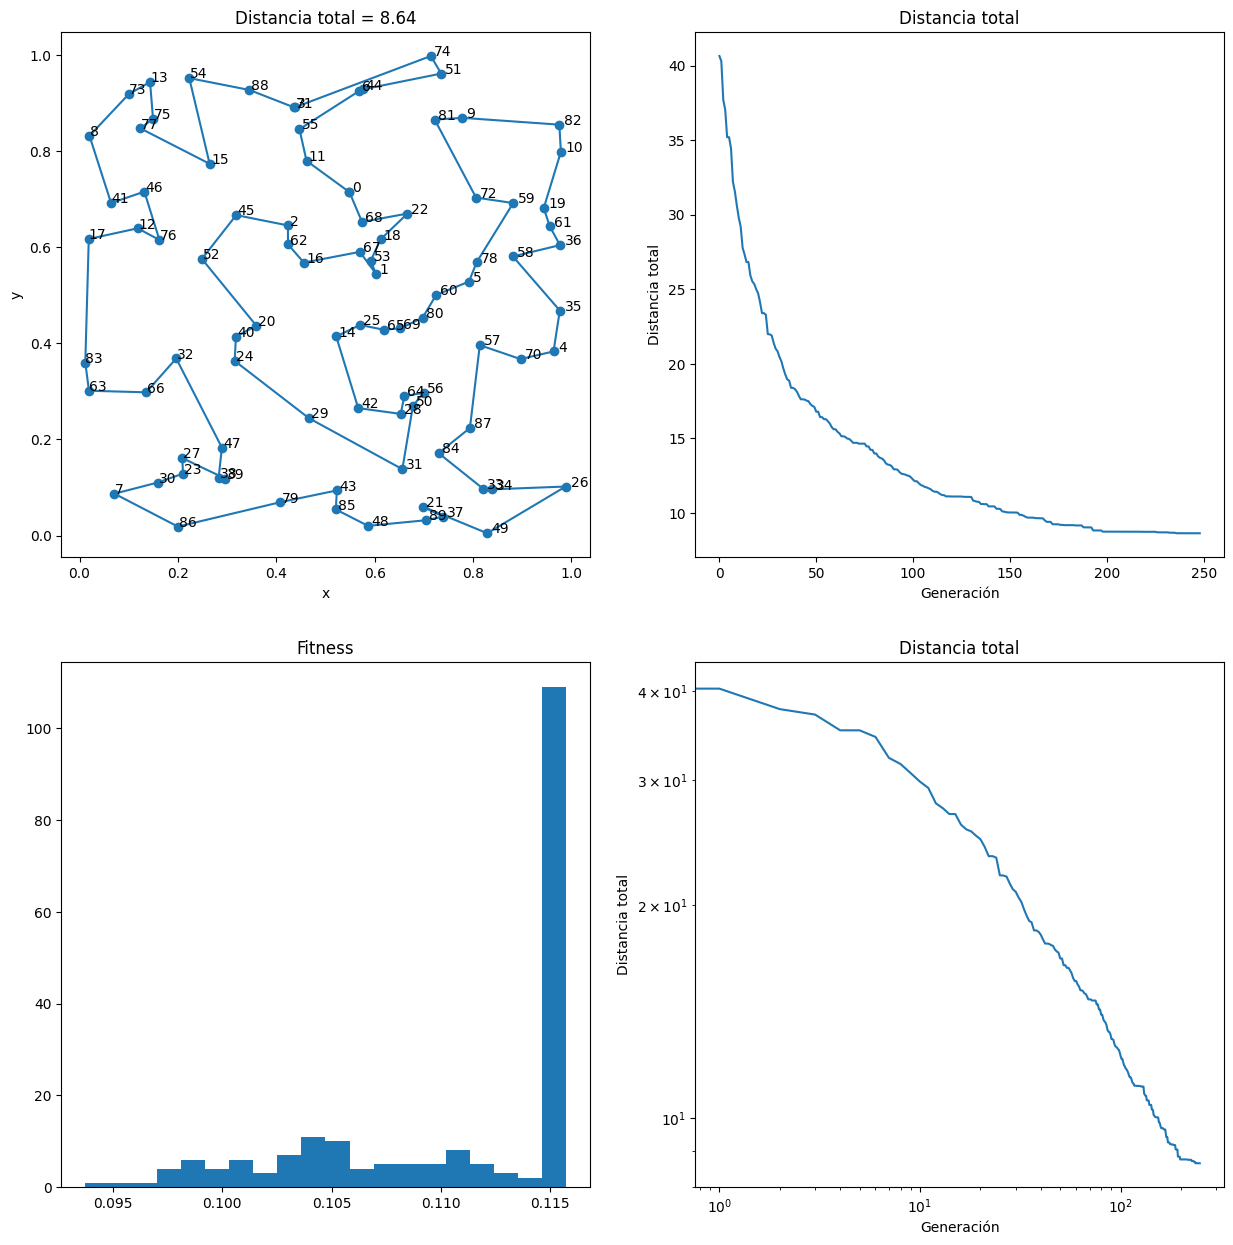

In [2]:
# Creamos las ciudades 
np.random.seed(0)
X = ciudades(90)

# Ejecutamos el algoritmo genético
inicial = X
ge = GeneticAlgorithm(inicial, stopcriteria=100 ,generations=300, mutationRate=0.5, poblationSize=200, elitism=True, elitePercentage=0.05, tournamentSize=10)
ge.run()


Generación 55/100
Distancia total = 5.18


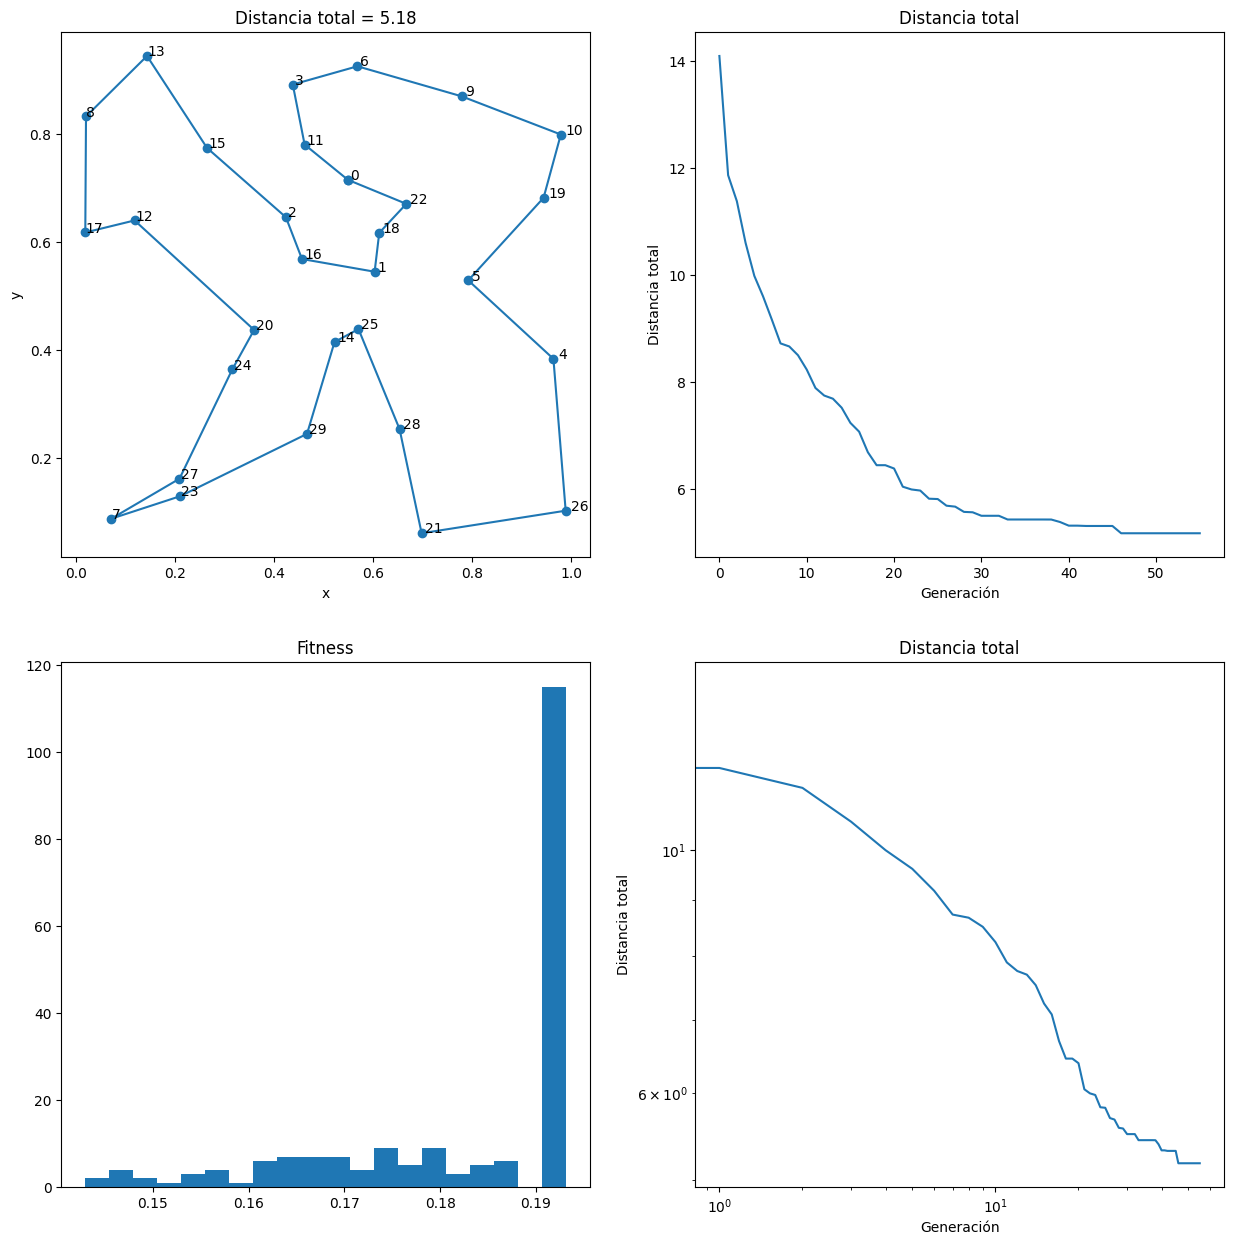

In [38]:
np.random.seed(0)
ge = GeneticAlgorithm(ciudades(30), generations=100, mutationRate=0.5, poblationSize=200, elitism=True, elitePercentage=0.05, tournamentSize=10)
ge.generations = 100
ge.graficRun()